In [1]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
train_data = pd.read_csv('FeatureEngineeredTrain.csv')
test_data = pd.read_csv('FeatureEngineeredTest.csv')

In [3]:
train_data['PricingStrategy'] = train_data['PricingStrategy'].replace({0:1, 1:2, 2:3})
test_data['PricingStrategy'] = test_data['PricingStrategy'].replace({0:1, 1:2, 2:3})

In [4]:
train_data['Charges_per_Pricing'] = train_data['ExtraCharges']/train_data['PricingStrategy']
test_data['Charges_per_Pricing'] = test_data['ExtraCharges']/test_data['PricingStrategy']

In [5]:
def time_in_seconds(time_series):
    time = time_series.split(' ')[1].split(':')
    hr, mn, sec = int(time[0]), int(time[1]), int(time[2])
    return hr*3600 + mn*60 + sec

train_data['Time_in_Secs'] = train_data['Time'].map(time_in_seconds)
test_data['Time_in_Secs'] = test_data['Time'].map(time_in_seconds)

In [6]:
train_data['Cyclic_Time_x'] = train_data['Time_in_Secs'].map(lambda x: math.sin(2*math.pi*x/86400))
train_data['Cyclic_Time_y'] = train_data['Time_in_Secs'].map(lambda x: math.cos(2*math.pi*x/86400))

test_data['Cyclic_Time_x'] = test_data['Time_in_Secs'].map(lambda x: math.sin(2*math.pi*x/86400))
test_data['Cyclic_Time_y'] = test_data['Time_in_Secs'].map(lambda x: math.cos(2*math.pi*x/86400))

train_data.drop('Time_in_Secs', axis=1, inplace=True)
test_data.drop('Time_in_Secs', axis=1, inplace=True)

In [7]:
train_data['TransactionStartTime'].sample()#.values[0].split('T')[0].split('-')[2]

62908    2019-01-18T05:25:23Z
Name: TransactionStartTime, dtype: object

In [8]:
def week_of_trans(time_series):
    time = time_series.split('T')[0].split('-')
    day = int(time[2])
    
    if day in range(1, 8):
        return 'first_week'
    elif day in range(8, 15):
        return 'second_week'
    elif day in range(15, 22):
        return 'third_week'
    elif day in range(22, 29):
        return 'fourth_week'
    else:
        return 'fifth_week'
    
train_data['Week'] = train_data['TransactionStartTime'].map(week_of_trans)
test_data['Week'] = test_data['TransactionStartTime'].map(week_of_trans)

In [9]:
train_data['Amount_to_mean_CustomerId'] = train_data['Amount']/train_data.groupby('CustomerId')['Amount'].transform('mean')
train_data['Amount_to_std_CustomerId'] = train_data['Amount']/train_data.groupby('CustomerId')['Amount'].transform('std')

train_data['Amount_to_mean_ProviderId'] = train_data['Amount']/train_data.groupby('ProviderId')['Amount'].transform('mean')
train_data['Amount_to_std_ProviderId'] = train_data['Amount']/train_data.groupby('ProviderId')['Amount'].transform('std')

train_data['Amount_to_mean_PricingStrategy'] = train_data['Amount']/train_data.groupby('PricingStrategy')['Amount'].transform('mean')
train_data['Amount_to_std_PricingStrategy'] = train_data['Amount']/train_data.groupby('PricingStrategy')['Amount'].transform('std')

train_data['Amount_to_mean_ProductCategory'] = train_data['Amount']/train_data.groupby('ProductCategory')['Amount'].transform('mean')
train_data['Amount_to_std_ProductCategory'] = train_data['Amount']/train_data.groupby('ProductCategory')['Amount'].transform('std')

train_data['Amount_to_mean_ChannelId'] = train_data['Amount']/train_data.groupby('ChannelId')['Amount'].transform('mean')
train_data['Amount_to_std_ChannelId'] = train_data['Amount']/train_data.groupby('ChannelId')['Amount'].transform('std')

train_data['Amount_to_mean_ProductId'] = train_data['Amount']/train_data.groupby('ProductId')['Amount'].transform('mean')
train_data['Amount_to_std_ProductId'] = train_data['Amount']/train_data.groupby('ProductId')['Amount'].transform('std')

In [10]:
train_data['Amount_to_std_CustomerId'].head()

0    0.328699
1   -0.006574
2         inf
3    1.164874
4   -0.037509
Name: Amount_to_std_CustomerId, dtype: float64

In [11]:
test_data['Amount_to_mean_CustomerId'] = test_data['Amount']/test_data.groupby('CustomerId')['Amount'].transform('mean')
test_data['Amount_to_std_CustomerId'] = test_data['Amount']/test_data.groupby('CustomerId')['Amount'].transform('std')

test_data['Amount_to_mean_ProviderId'] = test_data['Amount']/test_data.groupby('ProviderId')['Amount'].transform('mean')
test_data['Amount_to_std_ProviderId'] = test_data['Amount']/test_data.groupby('ProviderId')['Amount'].transform('std')

test_data['Amount_to_mean_PricingStrategy'] = test_data['Amount']/test_data.groupby('PricingStrategy')['Amount'].transform('mean')
test_data['Amount_to_std_PricingStrategy'] = test_data['Amount']/test_data.groupby('PricingStrategy')['Amount'].transform('std')

test_data['Amount_to_mean_ProductCategory'] = test_data['Amount']/test_data.groupby('ProductCategory')['Amount'].transform('mean')
test_data['Amount_to_std_ProductCategory'] = test_data['Amount']/test_data.groupby('ProductCategory')['Amount'].transform('std')

test_data['Amount_to_mean_ChannelId'] = test_data['Amount']/test_data.groupby('ChannelId')['Amount'].transform('mean')
test_data['Amount_to_std_ChannelId'] = test_data['Amount']/test_data.groupby('ChannelId')['Amount'].transform('std')

test_data['Amount_to_mean_ProductId'] = test_data['Amount']/test_data.groupby('ProductId')['Amount'].transform('mean')
test_data['Amount_to_std_ProductId'] = test_data['Amount']/test_data.groupby('ProductId')['Amount'].transform('std')

In [12]:
train_data = train_data.replace([np.inf, -np.inf], np.nan)
test_data = test_data.replace([np.inf, -np.inf], np.nan)

In [13]:
train_data.isin([np.inf, -np.inf, np.nan]).all(axis='columns').value_counts()

False    95662
dtype: int64

In [14]:
np.where(train_data.isnull().sum()>0)

(array([133, 134, 140, 144], dtype=int64),)

In [15]:
train_data.columns[np.where(train_data.isnull().sum()>0)]

Index(['Amount_to_mean_CustomerId', 'Amount_to_std_CustomerId',
       'Amount_to_std_ProductCategory', 'Amount_to_std_ProductId'],
      dtype='object')

In [16]:
original_train = train_data.copy()
original_test = test_data.copy()

In [17]:
null_cols = train_data.columns[np.where(train_data.isnull().sum()>0)]

for col in null_cols:
    train_data[col] = train_data[col].fillna(train_data[col].mean())
    test_data[col] = test_data[col].fillna(test_data[col].mean())

In [137]:
train_data.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 
                 'TransactionStartTime', 'Past_one_Week', 'Date'], 
                axis=1, inplace=True
               )

testTransId = test_data['TransactionId']
test_data.drop(['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 
                 'TransactionStartTime', 'Past_one_Week', 'Date'], 
                axis=1, inplace=True
               )

In [138]:
train_data.drop('Time', axis=1, inplace=True)
test_data.drop('Time', axis=1, inplace=True)

In [139]:
cat_columns = ['Year']

for col in cat_columns:
    train_data[col] = train_data[col].astype(str)
    test_data[col] = test_data[col].astype(str)

In [140]:
train_data.drop('Hour', axis=1, inplace=True)
test_data.drop('Hour', axis=1, inplace=True)

In [141]:
train_data.shape

(95662, 135)

In [142]:
test_data.shape

(45019, 134)

In [143]:
train_data.select_dtypes(include='object').columns

Index(['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Year',
       'Month', 'Weekday', 'Weekday/Weekend', 'Holiday', 'Form', 'Suspicious',
       'Multiple_Sub_by_Customer', 'Multiple_Sub_by_Acc', 'Week'],
      dtype='object')

In [144]:
fraudResult = train_data['FraudResult']

train_num = train_data.drop('FraudResult', axis=1).select_dtypes(exclude='object')
test_num = test_data.select_dtypes(exclude='object')

train_cat = train_data.select_dtypes(include='object')
test_cat = test_data.select_dtypes(include='object')

train_cat['label'] = 1
test_cat['label'] = 0

C:\Users\USER\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\USER\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [145]:
combined = pd.concat([train_cat, test_cat], axis=0)#.reset_index(drop=True)

In [146]:
combined = pd.get_dummies(combined, columns=combined.columns[:-1], drop_first=True)

train_cat = combined[combined['label']==1]
test_cat = combined[combined['label']==0]

In [147]:
train_cat.drop('label', axis=1, inplace=True)
test_cat.drop('label', axis=1, inplace=True)

C:\Users\USER\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [148]:
train_data = pd.concat([train_num, train_cat, fraudResult], axis=1)
test_data = pd.concat([test_num, test_cat], axis=1)

In [149]:
np.where(train_data.isnull().sum()>0)

(array([], dtype=int64),)

In [150]:
train_data.to_csv('FinalTrain.csv', index=False)
test_data.to_csv('FinalTest.csv', index=False)

In [25]:
X, y = train_data.drop('FraudResult', axis=1), train_data['FraudResult']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [26]:
#from sklearn.preprocessing import StandardScaler

In [27]:
#original_test_data = test_data.copy()

In [28]:
#scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

#X_train.loc[:, train_num.columns] = scaler.fit_transform(X_train.loc[:, train_num.columns])
#X_test.loc[:, train_num.columns] = scaler.transform(X_test.loc[:, train_num.columns])
#test_data.loc[:, train_num.columns] = scaler.transform(test_data.loc[:, train_num.columns])

In [29]:
X_test.head()

,Amount,PricingStrategy,No. Customers per Acc,ExtraCharges,Days_to_Nearest_Holiday,Prev_Amt,Time_since_last_trans,Avg_amt_per_ProviderId_in_last_12hhrs,sum_of_amt_per_ProviderId_in_last_12hhrs,max_amt_per_ProviderId_in_last_12hhrs,...,Hour_7,Hour_8,Hour_9,Weekday/Weekend_Weekend,Holiday_Yes,Form_Debit,Suspicious_Suspicious,Suspicious_Very Suspicious,Multiple_Sub_by_Customer_Yes,Multiple_Sub_by_Acc_Yes
13447,-70.0,3,30893,0.0,23,3500.0,0.333333,-232.500000,-930.0,-18.0,...,0,0,0,0,0,0,0,0,1,1
26074,-75.0,3,30893,0.0,11,1500.0,0.416667,-76.071429,-1065.0,-20.0,...,1,0,0,0,0,0,0,0,1,1
65964,2000.0,3,359,0.0,6,1500.0,12.966667,2014.285714,14100.0,5000.0,...,1,0,0,0,0,1,0,0,1,0
89786,10000.0,3,3,0.0,8,1000.0,2.200000,10000.000000,10000.0,10000.0,...,0,0,0,0,0,1,0,0,1,0
16997,20000.0,3,66,1800.0,21,-100.0,173.900000,12500.000000,25000.0,20000.0,...,0,0,0,0,0,1,0,0,1,0


In [30]:
from sklearn.utils import resample

In [31]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_fraud = X[X.FraudResult==0]
fraud = X[X.FraudResult==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.FraudResult.value_counts()

y_train_upsampled = upsampled.FraudResult
X_train_upsampled = upsampled.drop('FraudResult', axis=1)

In [32]:
y_train_upsampled.value_counts()

1    76375
0    76375
Name: FraudResult, dtype: int64

In [33]:
# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.FraudResult.value_counts()

y_train_downsampled = downsampled.FraudResult
X_train_downsampled = downsampled.drop('FraudResult', axis=1)

In [34]:
y_train_downsampled.value_counts()

1    154
0    154
Name: FraudResult, dtype: int64

In [31]:
from sklearn.model_selection import TimeSeriesSplit

In [32]:
cv = StratifiedKFold(n_splits=5, random_state=42)
tss = TimeSeriesSplit(n_splits=5)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import RFE

<h2>Random Forest</h2>

In [43]:
#cost-sensitive classification
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [44]:
rfc_cost_score = cross_val_score(rfc, X_train, y_train, scoring='f1', cv=tss, n_jobs=-1).mean()
rfc_cost_score

0.8327619250983535

In [43]:
print('Precision: {}'.format(cross_val_score(rfc, X_train, y_train, scoring='precision', cv=tss, n_jobs=-1).mean()))
print('Recall: {}'.format(cross_val_score(rfc, X_train, y_train, scoring='recall', cv=tss, n_jobs=-1).mean()))

Precision: 0.8606489886924669
Recall: 0.8366114561766735


In [44]:
rfc_train_cost = f1_score(y_train, rfc.predict(X_train))
rfc_test_cost = f1_score(y_test, rfc.predict(X_test))

print(rfc_train_cost)
print(rfc_test_cost)

1.0
0.8799999999999999


In [45]:
rfc_importances = rfc.feature_importances_
rfc_features = X_train.columns

rfc_feat_importances = pd.DataFrame({'Feat.' : rfc_features, 'Importances' : rfc_importances}).sort_values(by='Importances', ascending=False)
rfc_feat_importances[:12]

,Feat.,Importances
0,Amount,0.105480
115,Amount_to_mean_ChannelId,0.064642
116,Amount_to_std_ChannelId,0.053603
112,Amount_to_std_PricingStrategy,0.049519
114,Amount_to_std_ProductCategory,0.041533
7,Avg_amt_per_ProviderId_in_last_12hhrs,0.034030
113,Amount_to_mean_ProductCategory,0.025987
9,max_amt_per_ProviderId_in_last_12hhrs,0.023784
13,max_amt_per_ProviderId_in_last_24hhrs,0.022635
111,Amount_to_mean_PricingStrategy,0.022162


<h4>Feature Importance</h4>

In [46]:
#with top 12 features
rfc_12 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rfc_12.fit(X_train.loc[:, rfc_feat_importances['Feat.'][:12]], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
rfc_12_score = cross_val_score(rfc_12, X_train.loc[:, rfc_feat_importances['Feat.'][:12]], y_train, scoring='f1', cv=tss, n_jobs=-1).mean()
rfc_12_score

0.8951491156708548

In [48]:
print('Precision: {}'.format(cross_val_score(rfc_12, X_train.loc[:, rfc_feat_importances['Feat.'][:12]], y_train, scoring='precision', cv=tss, n_jobs=-1).mean()))
print('Recall: {}'.format(cross_val_score(rfc_12, X_train.loc[:, rfc_feat_importances['Feat.'][:12]], y_train, scoring='recall', cv=tss, n_jobs=-1).mean()))

Precision: 0.9526621715880028
Recall: 0.8471244536461928


In [99]:
rfc_train_12 = f1_score(y_train, rfc_12.predict(X_train.loc[:, rfc_feat_importances['Feat.'][:12]]))
rfc_test_12 = f1_score(y_test, rfc_12.predict(X_test.loc[:, rfc_feat_importances['Feat.'][:12]]))

print(rfc_train_12)
print(rfc_test_12)

0.9837133550488599
0.9066666666666667


In [50]:
test_predictions = rfc_12.predict(test_data.loc[:, rfc_feat_importances['Feat.'][:12]])

submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : test_predictions})
submission.to_csv('rfc_12_initial.csv', index=False)

<h2>XGBOOST</h2>

In [48]:
#cost sensitive

In [35]:
xgbm = xgb.XGBClassifier(n_jobs=-1, random_state=42, scale_pos_weight=496)
xgbm.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=496, seed=None, silent=None,
       subsample=1, verbosity=1)

In [46]:
cross_val_score(xgbm, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, verbose=0).mean()

0.8492524435366249

In [47]:
train_predictions = xgbm.predict(X_train)
test_predictions = xgbm.predict(X_test)

print('Train Score: {:4f}'.format(f1_score(y_train, train_predictions)))
print('Test Score: {:4f}'.format(f1_score(y_test, test_predictions)))

Train Score: 0.890173
Test Score: 0.774194


In [50]:
confusion_matrix(y_test, xgbm.predict(X_test))

array([[19076,    18],
       [    3,    36]], dtype=int64)

In [65]:
#undersampling

In [68]:
f1_under = []

for train, test in tss.split(X_train, y_train):
    X = pd.concat([X_train.iloc[train], y_train.iloc[train]], axis=1)

    not_fraud = X[X.FraudResult==0]
    fraud = X[X.FraudResult==1]

    not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([not_fraud_downsampled, fraud])

    # checking counts
    downsampled.FraudResult.value_counts()

    y_train_downsampled = downsampled.FraudResult
    X_train_downsampled = downsampled.drop('FraudResult', axis=1)
    
    model = xgb.XGBClassifier(n_jobs=-1, random_state=42)
    model.fit(X_train_upsampled, y_train_upsampled)
    f1_under.append(f1_score(y_train.iloc[test], model.predict(X_train.iloc[test])))

print(np.mean(f1_under))

0.8035452015684574


In [67]:
#oversampling

In [69]:
f1_over = []

for train, test in tss.split(X_train, y_train):
    # concatenate our training data back together
    X = pd.concat([X_train, y_train], axis=1)

    # separate minority and majority classes
    not_fraud = X[X.FraudResult==0]
    fraud = X[X.FraudResult==1]

    # upsample minority
    fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([not_fraud, fraud_upsampled])

    # check new class counts
    upsampled.FraudResult.value_counts()

    y_train_upsampled = upsampled.FraudResult
    X_train_upsampled = upsampled.drop('FraudResult', axis=1)
    
    model = xgb.XGBClassifier(n_jobs=-1, random_state=42)
    model.fit(X_train_upsampled, y_train_upsampled)
    f1_over.append(f1_score(y_train.iloc[test], model.predict(X_train.iloc[test])))

print(np.mean(f1_over))

0.8922797520385177


In [70]:
cv

StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

In [72]:
xgbm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=496, seed=None, silent=None,
       subsample=1, verbosity=1)

In [73]:
from xgboost import plot_importance

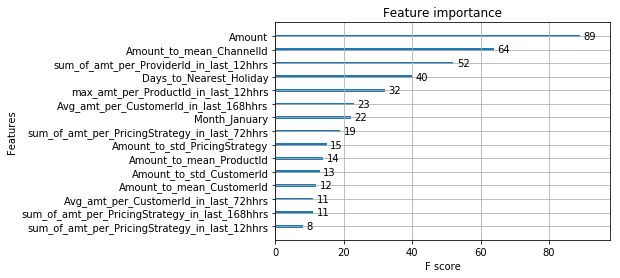

In [74]:
plot_importance(xgbm, max_num_features=15)

In [76]:
xgbm_ft_imp = xgbm.feature_importances_

importances = pd.DataFrame({'Feat.' : X_train.columns, 'Importance' : xgbm_ft_imp}).sort_values(by='Importance', ascending=False)
importances.head()

,Feat.,Importance
8,sum_of_amt_per_ProviderId_in_last_12hhrs,0.346181
115,Amount_to_mean_ChannelId,0.261299
79,Avg_amt_per_PricingStrategy_in_last_72hhrs,0.152574
6,Time_since_last_trans,0.052989
57,max_amt_per_ProductId_in_last_12hhrs,0.022151


In [36]:
xgbm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=496, seed=None, silent=None,
       subsample=1, verbosity=1)

In [43]:
predictions = xgbm.predict(test_data)


submission = pd.DataFrame({'TransactionId' : testTransId, 'FraudResult' : predictions})
submission.to_csv('submission.csv', index=False)


#0.5.....